## Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Step 1 

In [2]:
# Read the Excel file
file_path = "rawMeterData-123W93Street.xlsx"
xls = pd.ExcelFile(file_path)

data_frames = []  
for sheet_name in xls.sheet_names:
    df = xls.parse(sheet_name)
    data_frames.append(df)  

df_all = pd.concat(data_frames, ignore_index=True)  # 合并数据

# 确保 dateTimeStmp 是 datetime 类型
df_all['dateTimeStmp'] = pd.to_datetime(df_all['dateTimeStmp'])

# 按时间排序
df_all = df_all.sort_values(by='dateTimeStmp').reset_index(drop=True)

# 确保数据合并正确
print(df_all.info())  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131424 entries, 0 to 131423
Data columns (total 3 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   dateTimeStmp   131424 non-null  datetime64[ns]
 1   raw_MM_Wh      131424 non-null  float64       
 2   raw_Tenant_Wh  131424 non-null  float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 3.0 MB
None


In [3]:
# Read the Excel file
file_path = "rawMeterData-123W93Street.xlsx"  # Ensure the file path is correct
xls = pd.ExcelFile(file_path)

# Read all sheets (2021-2024)
data_frames = []
for sheet_name in xls.sheet_names:
    df = xls.parse(sheet_name)  # Parse each sheet
    df['Year'] = sheet_name  # Add a Year column to indicate the sheet's year
    data_frames.append(df)

# Merge data from all years into a single DataFrame
df_all = pd.concat(data_frames, ignore_index=True)

# Check the data format
df_all.head()  # Display the first few rows of the dataset

,dateTimeStmp,raw_MM_Wh,raw_Tenant_Wh,Year
0,2021-01-01 00:00:00,9516.17,6829.72,2021
1,2021-01-01 00:15:00,8710.08,6124.53,2021
2,2021-01-01 00:30:00,8123.25,6243.97,2021
3,2021-01-01 00:45:00,8097.63,6234.43,2021
4,2021-01-01 01:00:00,9140.92,6313.70,2021


In [4]:
print(df_all.info())  # Show dataset information

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131424 entries, 0 to 131423
Data columns (total 4 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   dateTimeStmp   131424 non-null  object 
 1   raw_MM_Wh      131424 non-null  float64
 2   raw_Tenant_Wh  131424 non-null  float64
 3   Year           131424 non-null  object 
dtypes: float64(2), object(2)
memory usage: 4.0+ MB
None


## Step2

In [5]:
# 2.1 Count the number of zero observations in raw_MM_Wh
zero_count = (df_all['raw_MM_Wh'] == 0).sum()

print(f"Total number of zero observations in raw_MM_Wh: {zero_count}")

Total number of zero observations in raw_MM_Wh: 3615


In [6]:
# 2.2 Count the number of consecutive zero sequences
from itertools import groupby

# Calculate the length of consecutive zero sequences and record start and end times
zero_streaks = []
start_times = []
end_times = []

# Iterate through the data to identify sequences of consecutive zeros
for key, group in groupby(enumerate(df_all['raw_MM_Wh']), key=lambda x: x[1] == 0):
    if key:  # Process only zero-value sequences
        group_list = list(group)
        streak_length = len(group_list)
        start_index = group_list[0][0]
        end_index = group_list[-1][0]
        
        zero_streaks.append(streak_length)
        start_times.append(df_all.loc[start_index, 'dateTimeStmp'])
        end_times.append(df_all.loc[end_index, 'dateTimeStmp'])

# Create a DataFrame with consecutive zero counts, start time, and end time
df_zero_streaks = pd.DataFrame({
    'Consecutive_Zero_Count': zero_streaks,
    'Start_Time': start_times,
    'End_Time': end_times
})

# Display summary statistics
print(df_zero_streaks.describe())

       Consecutive_Zero_Count
count              631.000000
mean                 5.729002
std                 81.027162
min                  1.000000
25%                  1.000000
50%                  1.000000
75%                  2.000000
max               1993.000000


C:\Users\Chris_y\AppData\Local\Temp\ipykernel_59404\3070426681.py:22: FutureWarning: Inferring datetime64[ns] from data containing strings is deprecated and will be removed in a future version. To retain the old behavior explicitly pass Series(data, dtype=datetime64[ns])
  df_zero_streaks = pd.DataFrame({


In [7]:
df_zero_streaks.head()  # Show first few streaks

,Consecutive_Zero_Count,Start_Time,End_Time
0,63,2021-07-06 19:45:00,2021-07-07 11:15:00
1,1993,2021-08-24 21:30:00,2021-09-14 15:30:00
2,1,2021-10-20 16:00:00,2021-10-20 16:00:00
3,1,2021-10-21 07:30:00,2021-10-21 07:30:00
4,1,2021-10-22 22:00:00,2021-10-22 22:00:00


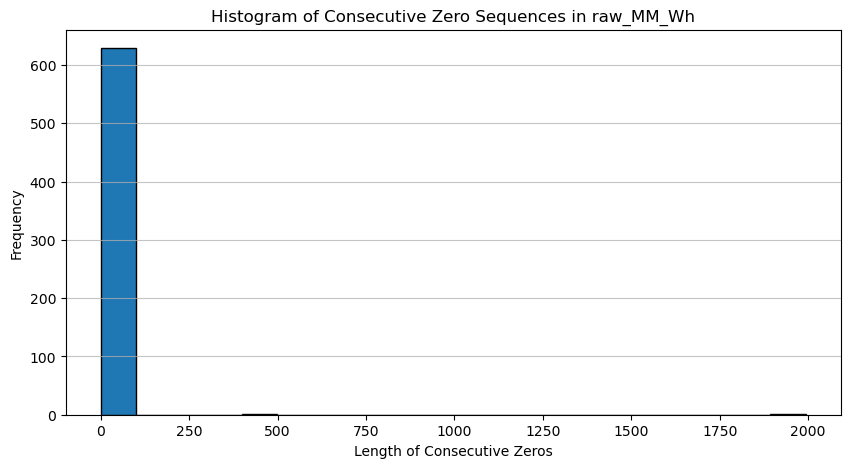

,Zero_Streak_Length,Frequency
0,1,419
1,2,121
2,3,48
3,4,13
4,5,12
5,6,7
6,7,2
7,8,2
11,9,1
12,27,1


In [8]:
# 2.3 Generate a histogram and tabular report of consecutive zeros
# Histogram of consecutive zero streaks
plt.figure(figsize=(10, 5))
plt.hist(df_zero_streaks['Consecutive_Zero_Count'], bins=20, edgecolor='black')
plt.xlabel("Length of Consecutive Zeros")
plt.ylabel("Frequency")
plt.title("Histogram of Consecutive Zero Sequences in raw_MM_Wh")
plt.grid(axis='y', alpha=0.75)
plt.show()

zero_streak_counts = df_zero_streaks['Consecutive_Zero_Count'].value_counts().reset_index()
zero_streak_counts.columns = ['Zero_Streak_Length', 'Frequency']
zero_streak_counts = zero_streak_counts.sort_values(by='Zero_Streak_Length')

# Create the DataFrame
df_zero_streak_counts = pd.DataFrame(zero_streak_counts)

# Display the DataFrame
df_zero_streak_counts

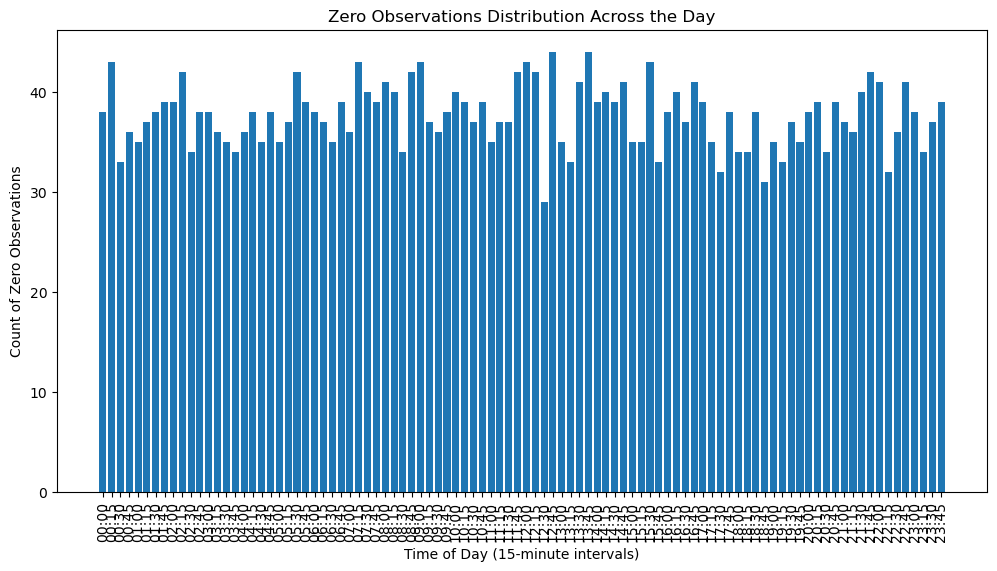

,TimeOfDay,Zero_Count
0,00:00,38
1,00:15,43
2,00:30,33
3,00:45,36
4,01:00,35
...,...,...
91,22:45,41
92,23:00,38
93,23:15,34
94,23:30,37


In [9]:
# 2.4 Analyze the time-of-day clustering of zero observations
# Convert timestamp to datetime format (if not already)
df_all['dateTimeStmp'] = pd.to_datetime(df_all['dateTimeStmp'])

# Extract time of day as hour and minute
df_all['TimeOfDay'] = df_all['dateTimeStmp'].dt.strftime('%H:%M')

# Filter out zero observations
df_zero_time = df_all[df_all['raw_MM_Wh'] == 0]

# Count occurrences per 15-minute interval
zero_time_counts = df_zero_time['TimeOfDay'].value_counts().sort_index()

# Plot histogram
plt.figure(figsize=(12, 6))
plt.bar(zero_time_counts.index, zero_time_counts.values, width=0.8)
plt.xticks(rotation=90)
plt.xlabel("Time of Day (15-minute intervals)")
plt.ylabel("Count of Zero Observations")
plt.title("Zero Observations Distribution Across the Day")
plt.show()

# Display tabular report
zero_time_counts.reset_index().rename(columns={'index': 'TimeOfDay', 'TimeOfDay': 'Zero_Count'})